# Detector Gain

This is a Jupyter notebook, which allows us to write and run Python code in a realtime, interactive fashion. There are two main kinds of cells

* Markdown cells like this one. We can make notes and write equations in  LaTeX (e.g, $e = mc^2$)

* Code cells like the one below. Type Shift-Enter to run a code cell.

In [7]:
# This is a comment.
print(1 + 1)

2


## Importing packages
We first need to import the packages we'll use to load, analyze, and visualize the data.

In [8]:
# Astropy is 
from astropy.io import fits

# Numpy is a powerful package for numerical analysis.
import numpy as np

# Matplotlib is the most popular Python plotting package.
import matplotlib.pyplot as plt

## Working with FITS files in Python
At their most basic, FITS files are just arrays of integers corresponding to the counts in each pixel. Usually FITS files also contain metadata in a header, such as the exposure time, or transformations from pixel coordinates to sky coordinates (RA and Dec.). The astropy fits package allows us to load FITS files as Numpy arrays, which we can then perform calculations on.

Note the call to `astype(np.int32)` at the end of `fits.getdata`. This is very important for getting the correct result for computer science reasons you can ignore if you want to. If you're interested in why this matters, see the end of the notebook.

#### Replace 'data/Flat.15S0X1.V.14.fits' with one of your images.

In [9]:
image = fits.getdata('CCD/slitview.00000357.FLAT.FIT').astype(np.int32)
print(image.shape)
print('')
print(image)

(495, 657)

[[  243   340   415 ...   468   405   455]
 [  473   456   558 ...   677   625   589]
 [  583   421   482 ...   681   545   617]
 ...
 [ 7863  7732  7580 ... 10764 10184 10104]
 [ 7809  7620  7822 ... 10717 10385 10103]
 [ 7540  7662  7632 ... 10317 10192 10347]]


We can see that the image is just a 1472 x 2184 array of integers.

## Load Images
Using the `fits.getdata` function, Load the two flat images and two bias images that you will use to calculate the gain. Remembers to put `.astype(np.int32)` at the end

In [10]:
flat1 = fits.getdata('CCD/slitview.00000357.FLAT.FIT').astype(np.int32)
flat2 = fits.getdata('CCD/slitview.00000359.FLAT.FIT').astype(np.int32)
bias1 = fits.getdata('CCD/slitview.00000353.BIAS.FIT').astype(np.int32)
bias2 = fits.getdata('CCD/slitview.00000356.BIAS.FIT').astype(np.int32)

You can write Equation 3 in code much like it appears in the instructions. You can make variables that are the same as the variables in the equation.

* For the mean: `mean_f1 = np.mean(flat1)`
* For the squared standard deviation of the image difference ($\sigma^2$): `sigma_f1f2 = np.std(flat_1 - flat_2)`

In the cell below, write out the equation. Use parentheses to ensure the correct order of operations.

In [11]:
mean_f1 = np.mean(flat1)
print(mean_f1)

mean_f2 = np.mean(flat2)
print(mean_f2)

mean_b1 = np.mean(bias1)
print(mean_b1)

mean_b2 = np.mean(bias2)
print(mean_b2)

sigma_f1f2 = np.std(flat1 - flat2)
print(sigma_f1f2)

sigma_b1b2 = np.std(bias1 - bias2)
print(sigma_b1b2)

gain = ((mean_f1+mean_f2)-(mean_b1+mean_b2))/(sigma_f1f2**2-sigma_b1b2**2)
print(1/gain)

17697.9642574912
17669.282514644157
107.69197915225313
111.65536952477592
285.4147219726822
52.1802907629895
2.24021298758132


### Read noise
Calculate the read noise. The square root function is `np.sqrt()`

In [12]:
read_noise = (gain*sigma_b1b2)/np.sqrt(2)

print(read_noise)

16.470325655344087


## Working with Subregions
Is your gain value close to the manufacturer's specification (1.3 e-/ADU)? What happens when you calculate the gain for a subregion of the detector? In the example below, we select a 100 x 100 pixel sub region from `row0` to `row1` and `colm0` to `colm1`.

In [13]:
row0 = 100
row1 = 200
colm0 = 200
colm1 = 300

# This is called taking a 'slice' of the array, i.e. a subregion
sub_flat1 = flat1[row0:row1, colm0:colm1]
sub_flat2 = flat2[row0:row1, colm0:colm1]
sub_bias1 = bias1[row0:row1, colm0:colm1]
sub_bias2 = bias2[row0:row1, colm0:colm1]

#print(sub_image.shape)
#print('')
#print(sub_image)

Now try calculating the gain in different subregions by varying `row0`, `row1`, `colm0`, and `colm1` Try different sizes, e.g. 100 x 100, 200 x 200, etc

In [14]:
row0 = 100
row1 = 200
colm0 = 200
colm1 = 300

sub_mean_f1 = np.mean(sub_flat1)
print(sub_mean_f1)

sub_mean_f2 = np.mean(sub_flat2)
print(sub_mean_f2)

sub_mean_b1 = np.mean(sub_bias1)
print(sub_mean_b1)

sub_mean_b2 = np.mean(sub_bias2)
print(sub_mean_b2)

sub_sigma_f1f2 = np.std(sub_flat1 - sub_flat2)
print(sub_sigma_f1f2)

sub_sigma_b1b2 = np.std(sub_bias1 - sub_bias2)
print(sub_sigma_b1b2)

sub_gain = ((sub_mean_f1+sub_mean_f2)-(sub_mean_b1+sub_mean_b2))/(sub_sigma_f1f2**2-sub_sigma_b1b2**2)
print(1/sub_gain)

sub_read_noise = (sub_gain*(sub_sigma_b1b2))/np.sqrt(2)
print(sub_read_noise)

21156.9494
21118.5921
112.2998
116.4918
312.0991842935672
52.20840484060014
2.251783634309153
16.394522340085768


## Adding Bells and Whistles

Below is a little more advanced Python programming. You can try running it on your own data and tweaking the code to see how it works. 

You probably found varying and typing everything out by hand to be a bit tedious. Alternatively, we can write a function to calculate the gain. The text in triple quotations is called the doc(umentation)string. It tells the user what the function does, what the arguments are, and what the function returns.

In [15]:
def calculate_gain(flat1, flat2, bias1, bias2):
    """
    Calculate detector gain given two flat frames and two bias frames.
    
    Parameters
    ----------
    flat_1, flat_2 : numpy.array_like
        The flat frames
    bias_1, bias_2 : numpy.array_like
        The bias frames
        
    Returns
    -------
    gain : float
        The detector gain
    """
    # This is Equation 3 from the assignment
    numerator = (np.mean(flat1) + np.mean(flat2)) - (np.mean(bias1) + np.mean(bias2))
    denominator = np.std((flat1 - flat2)) ** 2 - np.std((bias1 - bias2)) ** 2
    gain = numerator / denominator
    
    return gain

##### Replace these files with your own data to try out the code.

In [20]:
1/calculate_gain(flat1, flat2, bias1, bias2)

2.24021298758132

## Calculating the gain in different subregions
We can divide the detector up into a grid of subregions. The `bins` are the row and column boundaries of the subregions. Effectively we are making a coarse "map" of the gain calculated on different parts of the detector.

In [16]:
row_bins = np.linspace(0, flat1.shape[0], 5).astype(int)
print(row_bins)
col_bins = np.linspace(0, flat1.shape[1], 10).astype(int)
print(col_bins)

[  0 123 247 371 495]
[  0  73 146 219 292 365 438 511 584 657]


In [17]:
# This is an array to store the gain in each subregion.
gain_map = np.zeros((len(row_bins) - 1, len(col_bins - 1)))

# This nested for loop goes through each subregion.
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_slice = slice(row_bins[ii], row_bins[ii + 1])
        col_slice = slice(col_bins[jj], col_bins[jj + 1])
        
        # The `local_gain` is the gain in the subregion
        local_gain = calculate_gain(flat1[row_slice, col_slice], flat2[row_slice, col_slice],
                                    bias1[row_slice, col_slice], bias2[row_slice, col_slice])
        
        # Store the local gain in the `gain_map`
        gain_map[ii, jj] = 1/local_gain

## Plot the gain values

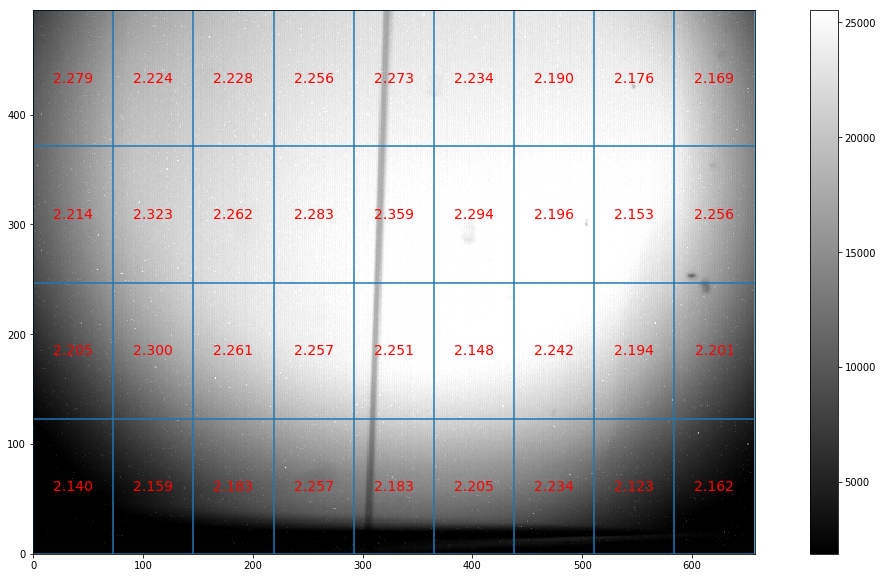

In [18]:
plt.figure(figsize=(20, 10))

# Use the imshow function to plot one of the flat images for reference.
plt.imshow(flat1, vmin=np.percentile(flat1, 5), vmax=np.percentile(flat1, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')


# Plot the boundaries of the subregions
for row in row_bins:
    plt.axhline(row)
for col in col_bins:
    plt.axvline(col)

# Print the local gain value in each subregion
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_loc = (row_bins[ii] + row_bins[ii + 1]) / 2
        col_loc = (col_bins[jj] + col_bins[jj + 1]) / 2
        
        plt.text(col_loc, row_loc, '{:.3f}'.format(gain_map[ii, jj]),
                 ha='center', va='center', fontsize=14, color='r')

plt.xlim(0, col_bins[-1])
plt.ylim(0, row_bins[-1])

# Add a colorbar
plt.colorbar()
plt.savefig('gainmap.png')

## Unsigned versus signed integers

As their names suggest, unsigned integers can only represent non-negative numbers. That's 0 up to $2^n - 1$, where $n$ is the number of bits the variable takes up in memory. Signed integers can have values from $-(2^{n-1})$ up to $2^{n - 1} - 1$.

Negative values have no real physical meaning on an astronomical image, so the negative values are a waste of memory. Therefore images are usually stored as unsigned integers.

The problem is when we need to subtract two sets of unsigned integers, like we did in the gain calculation. This can give weird results if we're not careful.

In [22]:
a = np.array([1], dtype=np.uint16)
b = np.array([3], dtype=np.uint16)

print('a =', a)
print('b =', b)
print('a - b =', a - b)

a = [1]
b = [3]
a - b = [65534]


We can fix this by converting the unsigned 16-bit integers to signed 32-bit integers.

In [23]:
a = a.astype(np.int32)
b = b.astype(np.int32)

print('a =', a)
print('b =', b)
print('a - b =', a - b)

a = [1]
b = [3]
a - b = [-2]
